# Рынок заведений общественного питания Москвы

## Описание: 
Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?\
Вы — гуру аналитики, и партнёры просят вас подготовить исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.

## Цель:
1. Проанализировав данные по заведениям Москвы, дать рекомендации для нового кафе о виде заведения, количестве посадочных мест, а также районе расположения.
2. Подготовить презентацию для инвесторов.

## Описание данных:
**id** — идентификатор объекта;\
**object_name** — название объекта общественного питания;\
**chain** — сетевой ресторан;\
**object_type** — тип объекта общественного питания;\
**address** — адрес;\
**number** — количество посадочных мест.

## Оглавление:
* [Шаг 1. Предобработка данных](#first_step)
     - [Вывод](#first_1_prestep)
* [Шаг №2. Анализ данных](#second_step):
    - График соотношения видов объектов общественного питания по количеству.
    - График соотношения сетевых и несетевых заведений по количеству.
    - Для какого вида объекта общественного питания характерно сетевое распространение?
    - Что характерно для сетевых заведений?
    - Среднее количество посадочных мест для каждого вида объекта общественного питания. График.
    - Извлечение в отдельный столбец информацию об улице из столбца address.
    - График топ-10 улиц по количеству объектов общественного питания. В каких районах Москвы находятся эти улицы?
    - Расчет числа улиц с одним объектом общественного питания.
    - Выявление закономерностей в распределении количества посадочных мест для улиц с большим количеством объектов общественного питания.
    - [Вывод и рекомендации](#second_1_prestep)
* [Шаг №3. Презентации](#third_step)

In [1]:
#импорт необходимых библиотек
import pandas as pd
import seaborn as sns
from numpy import median
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import re
import matplotlib
matplotlib.style.use('fivethirtyeight')
import numpy as np
%config InlineBackend.figure_format = 'retina'

### Шаг 1. Предобработка данных <a class="anchor" id="first_step"></a>

In [2]:
#загрузка данных
rest_data = pd.read_csv(r'C:\Users\dshf\Desktop\portfolio\Рынок заведений общественного питания Москвы\data\rest_data.csv')
rest_data.sample(7)

id               object_name chain object_type  \
270     82732                     Прайм    да        кафе   
11201  178737                      Дуэт   нет         бар   
3454    27013                      Бега   нет    ресторан   
7772    28995  ШКОЛА 1375 КШП «ЗАГОРЬЕ»   нет    столовая   
6835    22786                  Натюрлих   нет    ресторан   
7477   152405                  Столовая   нет    столовая   
1456   134075                  МАТРЕШКА   нет        кафе   

                                                 address  number  
270                 город Москва, Тверская улица, дом 15      20  
11201                город Москва, улица Руднёвка, дом 5      30  
3454                 город Москва, Беговая аллея, дом 11      50  
7772        город Москва, Нагатинская набережная, дом 24     300  
6835               город Москва, Юровская улица, дом 105      90  
7477   город Москва, Дербеневская набережная, дом 7, ...      20  
1456   город Москва, Новолучанская улица, дом 22, стр...      17

In [3]:
#информация по столбцам
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [4]:
#проверка на заглушки
rest_data['chain'].value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

___В датасете нет пропущенных значений. Все столбцы имеют правильный тип данных, но желательно поменять тип данных столбца chain на bool, тк там только два значения 'да' и 'нет'. Их можно заменить на True и False.___

In [5]:
print('Кол-во дубликатов по всем столбцам:', rest_data['id'].duplicated().sum())
print('Кол-во дубликатов по всем столбцам, кроме id:', rest_data[['object_name', 'chain', 'address', 'object_type', 'number']]\
      .duplicated().sum())

Кол-во дубликатов по всем столбцам: 0
Кол-во дубликатов по всем столбцам, кроме id: 82


___Если исключить из проверки дубликатов 'id', то можно предположить, что имея аналогичность по 5 столбцам(кроме 'id'), запись все таки возможно является дубликатом. Таких записей всего 82. Пока оставим их и попробуем найти еще дубликаты. Для начала изменим тип данных у столбца 'chain' на bool.___

In [6]:
#изменение типа данных столбца chain
rest_data['chain'] = rest_data['chain'].replace('нет', 0)
rest_data['chain'] = rest_data['chain'].replace('да', 1)
rest_data['chain'] = rest_data['chain'].astype('bool')

In [7]:
#решил укоротить название для удобства
rest_data['object_type'] = rest_data['object_type'].replace('предприятие быстрого обслуживания', 'предприятие быстр. обсл.')

In [8]:
#уникальные значения object_name
rest_data['object_name'].unique().tolist()

['СМЕТАНА',
 'Родник',
 'Кафе «Академия»',
 'ПИЦЦЕТОРИЯ',
 'Кафе «Вишневая метель»',
 'СТОЛ. ПРИ ГОУ СОШ № 1051',
 'Брусника',
 'Буфет МТУСИ',
 'КПФ СЕМЬЯ-1',
 'Столовая МТУСИ',
 'Пекарня 24',
 'Гогиели',
 'ШКОЛА 735',
 'Алло Пицца',
 'Гимназия 1542',
 'Школа 1011',
 'Суши Wok',
 'Донер Кебаб',
 'Тануки',
 'Американская Лаборатория Десертов',
 'Кафе',
 'КАФЕ УЮТ',
 'Долина Чайхона',
 'ГБОУ Школа № 1411 (970)',
 'Кафетерий',
 "Домино'с Пицца",
 'РАХИМКУЛОВА Т.Х.',
 'СТОЛОВАЯ ПРИ ГУП ОБЪЕДИНЕННЫЙ КОМБИНАТ ШКОЛЬНОГО ПИТАНИЯ',
 'ШКОЛА 1444',
 'Мархал',
 'Готика',
 'Гимназия № 1527',
 'Кафе «Хинкальная»',
 'Рыба & мясо на углях',
 'Кларом',
 'Месопотамия',
 'Му-Му',
 'Хлеб насущный',
 'TAJJ MAHAL',
 'Калифорния Дайнер',
 'Балалаечная',
 'Пиросмани',
 'ДАНКИН ДОНАТС',
 'Вареничная №1',
 'ШОКОЛАДНИЦА',
 'IL Pizzaiolo',
 'Теремок',
 'Мосбург',
 'Эрик Рыжий',
 'Домашняя снедь',
 'Хинкальная',
 'ВОСТОЧНЫЙ КВАРТАЛ',
 'ПОЧТМЕЙСТЕР',
 'БОСФОР',
 'Мастер',
 'Шантимель',
 'Буфет при Астраханских баня

___Решил полистать данные и посмотреть на названия заведений. Есть проблема с регистром и его надо привести к общему виду.___

In [9]:
#создание нового столбца с нижним регистром
rest_data['object_name_new'] = rest_data['object_name'].str.lower()

In [10]:
#Транслитерация
def transliterate(name):
   # Слоаврь с заменами
   slovar = {'а':'a','б':'b','в':'v','г':'g','д':'d','е':'e','ё':'yo',
      'ж':'zh','з':'z','и':'i','й':'i','к':'k','л':'l','м':'m','н':'n',
      'о':'o','п':'p','р':'r','с':'s','т':'t','у':'u','ф':'f','х':'h',
      'ц':'c','ч':'ch','ш':'sh','щ':'sch','ъ':'','ы':'y','ь':'','э':'e',
      'ю':'u','я':'ya', 'А':'A','Б':'B','В':'V','Г':'G','Д':'D','Е':'E','Ё':'YO',
      'Ж':'ZH','З':'Z','И':'I','Й':'I','К':'K','Л':'L','М':'M','Н':'N',
      'О':'O','П':'P','Р':'R','С':'S','Т':'T','У':'U','Ф':'F','Х':'H',
      'Ц':'C','Ч':'CH','Ш':'SH','Щ':'SCH','Ъ':'','Ы':'y','Ь':'','Э':'E',
      'Ю':'U','Я':'YA',',':'','?':'','~':'','!':'','@':'','#':'',
      '$':'','%':'','^':'','&':'','*':'','(':'',')':'','-':'','=':'','+':'',
      ':':'',';':'','<':'','>':'','\'':'','"':'','\\':'','/':'','№':'',
      '[':'',']':'','{':'','}':'','ґ':'','ї':'', 'є':'','Ґ':'g','Ї':'i',
      'Є':'e', '—':'', '«':'', '»':''}
        
   # Циклически заменяем все буквы в строке
   for key in slovar:
      name = name.replace(key, slovar[key])
   return name

___Так же можно убрать из названия кафе - само слово 'кафе', 'рестаран' и 'бар'.___

In [11]:
def filtr(name):
   # Слоаврь с заменами
   slovar = {'kafe ':'', 'restoran ':'', 'bar ':''}
        
   # Циклически заменяем все буквы в строке
   for key in slovar:
      name = name.replace(key, slovar[key])
   return name

In [12]:
#применение функций
rest_data['object_name_new'] = rest_data['object_name_new'].apply(transliterate)
rest_data['object_name_new'] = rest_data['object_name_new'].apply(filtr)

In [13]:
print('Новое кол-во дубликтов:', rest_data[['object_name_new', 'chain', 'address', 'object_type', 'number']].duplicated().sum())

Новое кол-во дубликтов: 85


__Кол-во дубликтов изменилось с 82 на 85. Скорее всего осталось некоторое количество необъединенных названий заведений из за проблемы перевода на латиницу, но их поиск возможен уже вручную.__

In [14]:
#удаление дубликатов
rest_data = rest_data.drop_duplicates(['object_name_new', 'chain', 'address', 'object_type', 'number'])

In [15]:
rest_data['object_name'].value_counts().head(7)

Столовая       267
Шаурма         226
Кафе           221
KFC            155
Шоколадница    142
Бургер Кинг    122
Макдоналдс     121
Name: object_name, dtype: int64

In [16]:
rest_data['object_name_new'].value_counts().head(7)

stolovaya       324
kafe            264
shaurma         244
shokoladnica    176
kfc             171
makdonalds      164
burger king     146
Name: object_name_new, dtype: int64

_Из за проблем с регистром и кириллицей многие заведения распознавались как разные. Сейчас они имеют одно название и соотвественно изменилось их количество._

In [17]:
rest_data.head()

id             object_name  chain object_type  \
0  151635                 СМЕТАНА  False        кафе   
1   77874                  Родник  False        кафе   
2   24309         Кафе «Академия»  False        кафе   
3   21894              ПИЦЦЕТОРИЯ   True        кафе   
4  119365  Кафе «Вишневая метель»  False        кафе   

                                             address  number   object_name_new  
0         город Москва, улица Егора Абакумова, дом 9      48           smetana  
1  город Москва, улица Талалихина, дом 2/1, корпус 1      35            rodnik  
2          город Москва, Абельмановская улица, дом 6      95         akademiya  
3            город Москва, Абрамцевская улица, дом 1      40       piccetoriya  
4  город Москва, Абрамцевская улица, дом 9, корпус 1      50  vishnevaya metel

In [18]:
rest_data['object_type'].value_counts()

кафе                         6071
столовая                     2584
ресторан                     2282
предприятие быстр. обсл.     1897
бар                           855
буфет                         576
кафетерий                     395
закусочная                    348
магазин (отдел кулинарии)     273
Name: object_type, dtype: int64

In [19]:
rest_data['address'].value_counts().head(7)

город Москва, Ходынский бульвар, дом 4            95
город Москва, Пресненская набережная, дом 2       63
город Москва, проспект Мира, дом 211, корпус 2    60
город Москва, Кировоградская улица, дом 13А       52
город Москва, площадь Киевского Вокзала, дом 2    47
город Москва, Мытная улица, дом 74                46
город Москва, улица Земляной Вал, дом 33          46
Name: address, dtype: int64

_Проверка на заглушки по столбцам object_type и address. Заглушек нет._

In [20]:
#распределение занчений number
rest_data['number'].describe()

count    15281.000000
mean        59.788234
std         74.843042
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

__Значение 0 имеет место быть, заведение может не иметь посадочные места, если оно работает навынос. Есть значение в 1700 посадочных мест. На первый взляд выглядит как аномальное значение.__

### Вывод: <a class="anchor" id="first_1_prestep"></a>

**В ходе изучения данных, был выявлен 1 неправильный тип данных у столбце 'chain'. Тип данных был изменени с str на bool. Столбец 'object_name' имел разный регистр и язык в называниях заведений. Данная ошибка была исправлена путем приведения значений солбца к нижнему регистру и перевод значения в латиницу. Так же из названий были удалены ковычки. В итоге, было найден 85 дубликтов, имеющих единственное отличие в столбце 'id' и было принято решение их удалить. Заглушек в данных не обнаружено.**

### Шаг 2. Анализ данных <a class="anchor" id="second_step"></a>

---
#### 1. График соотношения видов объектов общественного питания по количеству.

In [21]:
#группировка object_type по кол-ву ун. знач id
grouped_object_type = rest_data.groupby(['object_type']).agg({'id':'nunique'})\
.reset_index().sort_values('id', ascending=False)

In [22]:
fig = go.Figure(data=[go.Pie(labels=grouped_object_type['object_type'], values=grouped_object_type['id'])])
fig.update_layout(title_text='График соотношения видов объектов общественного питания по количеству.')
fig.show()

**Круговая диаграмма показывает, что абсолютный лидер среди заведений общественного питания это - кафе. Они составляют почти 40% от всех заведений в Москве. Столовые, рестораны и предприятия быстрого обслуживания имеют примерно одинаковые показатели( от 12.4% до 16.9%). В большинстве случаев, то, что наиболее популярно, имеет самое лучшее соотношение 'прибыль'/'затраты'.**

---
#### 2. График соотношения сетевых и несетевых заведений по количеству.

In [23]:
#группировка chain по кол-ву уникальных пользователей
grouped_chain = rest_data.groupby(['chain']).agg({'id':'nunique'}).reset_index().sort_values('id', ascending=False)

In [24]:
fig = go.Figure(data=[go.Pie(labels=grouped_chain['chain'], values=grouped_chain['id'])])
fig.update_layout(title_text='График соотношения сетевых и несетевых заведений по количеству.')
fig.show()

**Диаграмма показывает, что на одно сетевое заведение приходится 4 несетевых. Поискав информацию в сети, нашел совершенно противоречивые результаты. Где то результаты были совершенно противоположны моим, где то примерно как у меня. Полагаясь на текущие данные, можно сказать, что открытие несетевого заведение возможно в текущих реалиях и даже совершенно обосновано.**

---
#### 3. Для какого вида объекта общественного питания характерно сетевое распространение?

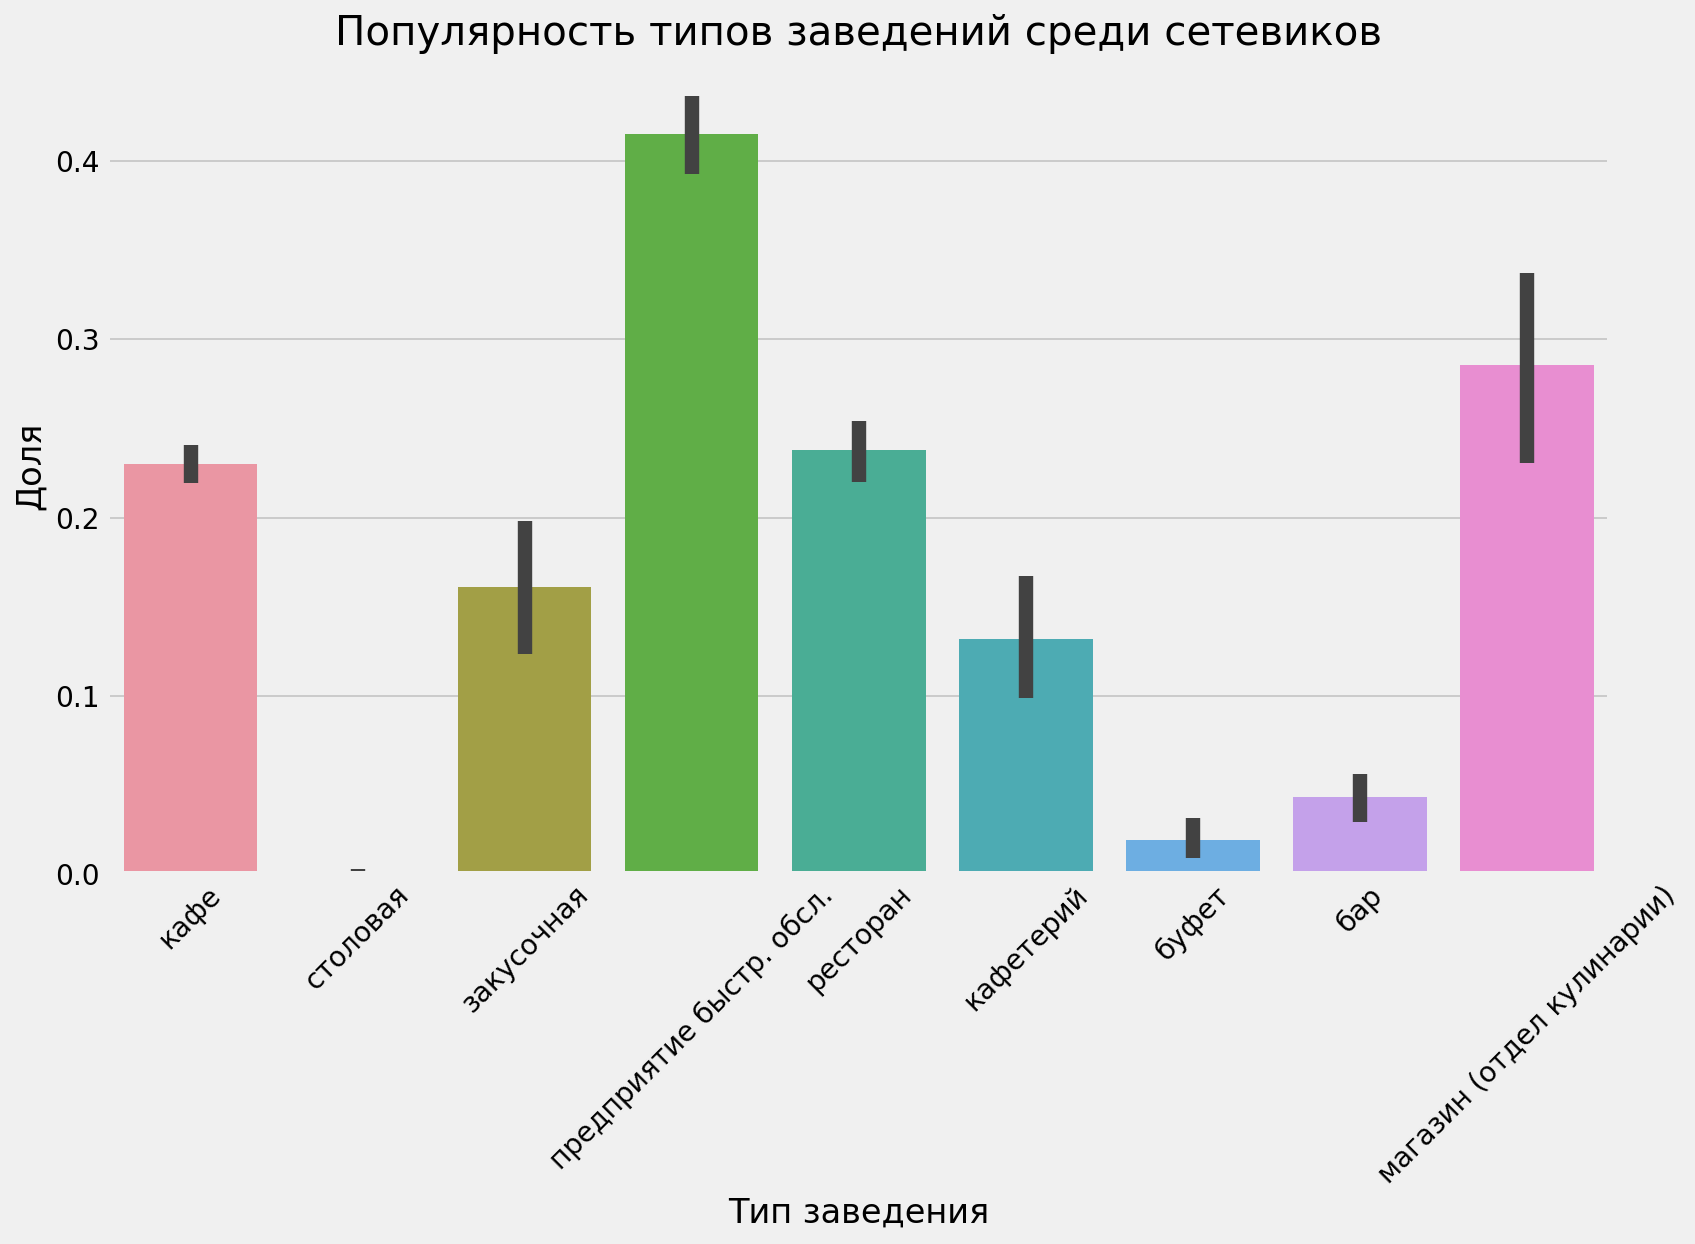

In [25]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x="object_type", y="chain", data=rest_data)
ax.set_title('Популярность типов заведений среди сетевиков')
ax.set_xlabel('Тип заведения')
ax.set_ylabel('Доля')
plt.xticks(rotation=45)
plt.show()

__Самый частый тип заведения, который открывают сетевики это - предприятие быстрого обслуживание. На втором месте - магазин(отдел кулинарии), третье - кафе. Самые несетевые типы - столовые, буфеты, бары. Т.е. по данному графику можно сделать вывод по самым привлекательным видам заведений для сетевика. Соответсвенно, если мы хотим открыть несетевое завление, то возможно не стоит открывать предприятие быстрого питания, тк конкурировать с сетью будет достаточно сложно. Магазин(отдел кулинарии) так же не очень подходит(даже из за самой концепции). Стоит присмотреться к кафе и ресторану.__

---
#### 4. Что характерно для сетевых заведений?
_Много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?_

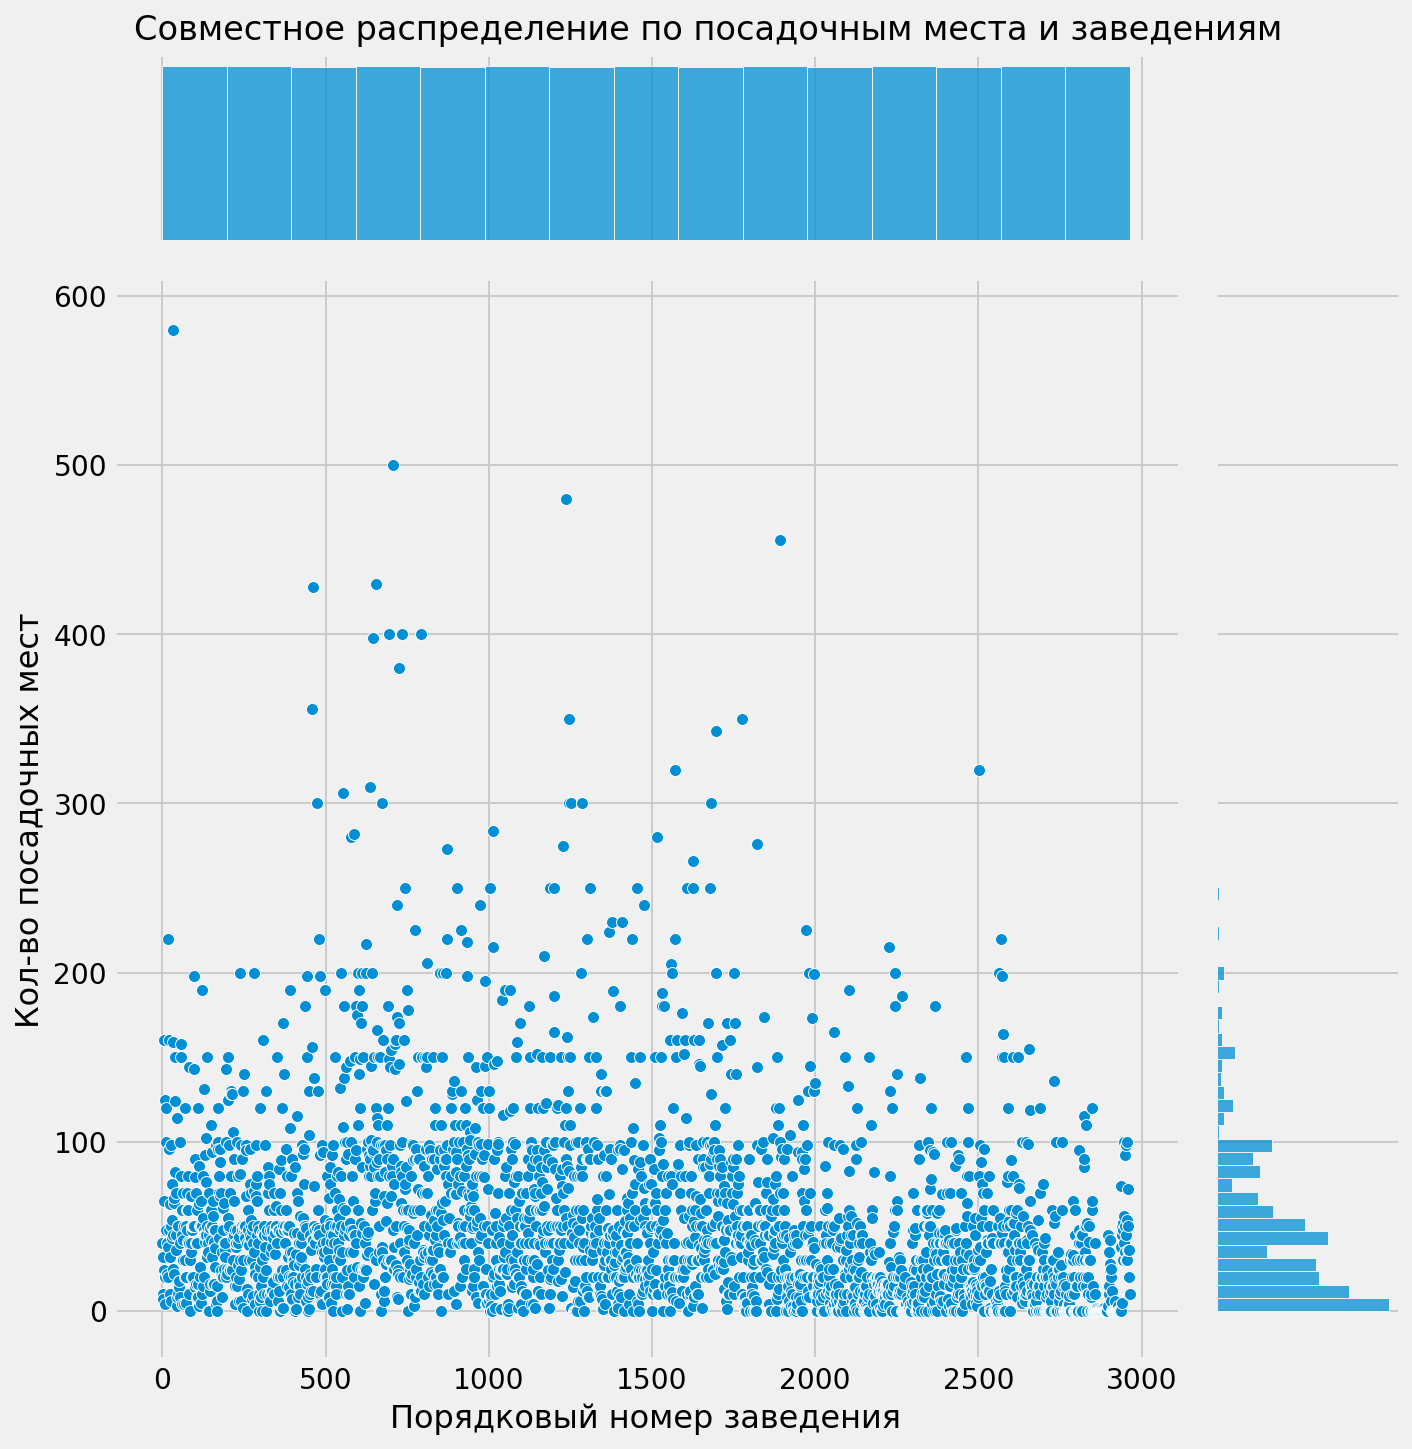

In [26]:
ax = sns.jointplot(data=rest_data[rest_data['chain'] == True], x=rest_data[rest_data['chain'] == True]\
              .reset_index().index, y='number', kind='scatter', height=10)
ax.fig.suptitle("Совместное распределение по посадочным места и заведениям")
ax.fig.subplots_adjust(top=0.95)
ax.set_axis_labels('Порядковый номер заведения', 'Кол-во посадочных мест', fontsize=16)


In [27]:
rest_data[rest_data['chain'] == True]['number'].describe()

count    2964.000000
mean       52.981107
std        57.152817
min         0.000000
25%        15.000000
50%        40.000000
75%        72.000000
max       580.000000
Name: number, dtype: float64

In [28]:
print('90 % заведений имеют до', np.percentile(rest_data[rest_data['chain'] == True]['number'], 90), 'посадочных мест')

90 % заведений имеют до 120.0 посадочных мест


___Если до 1500ого заведения четко видно скопление в значениях до 100, то уже после 2000го заведения среднее кол-во мест падает до 70-80. Т.е большинство сетевых заведений(75%) имеют до 72 посадочных мест и 90% заведений имеют до 120 посадочных мест.___

---
#### 5. Среднее количество посадочных мест для каждого вида объекта общественного питания. График.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'кафе'),
  Text(1, 0, 'столовая'),
  Text(2, 0, 'закусочная'),
  Text(3, 0, 'предприятие быстр. обсл.'),
  Text(4, 0, 'ресторан'),
  Text(5, 0, 'кафетерий'),
  Text(6, 0, 'буфет'),
  Text(7, 0, 'бар'),
  Text(8, 0, 'магазин (отдел кулинарии)')])

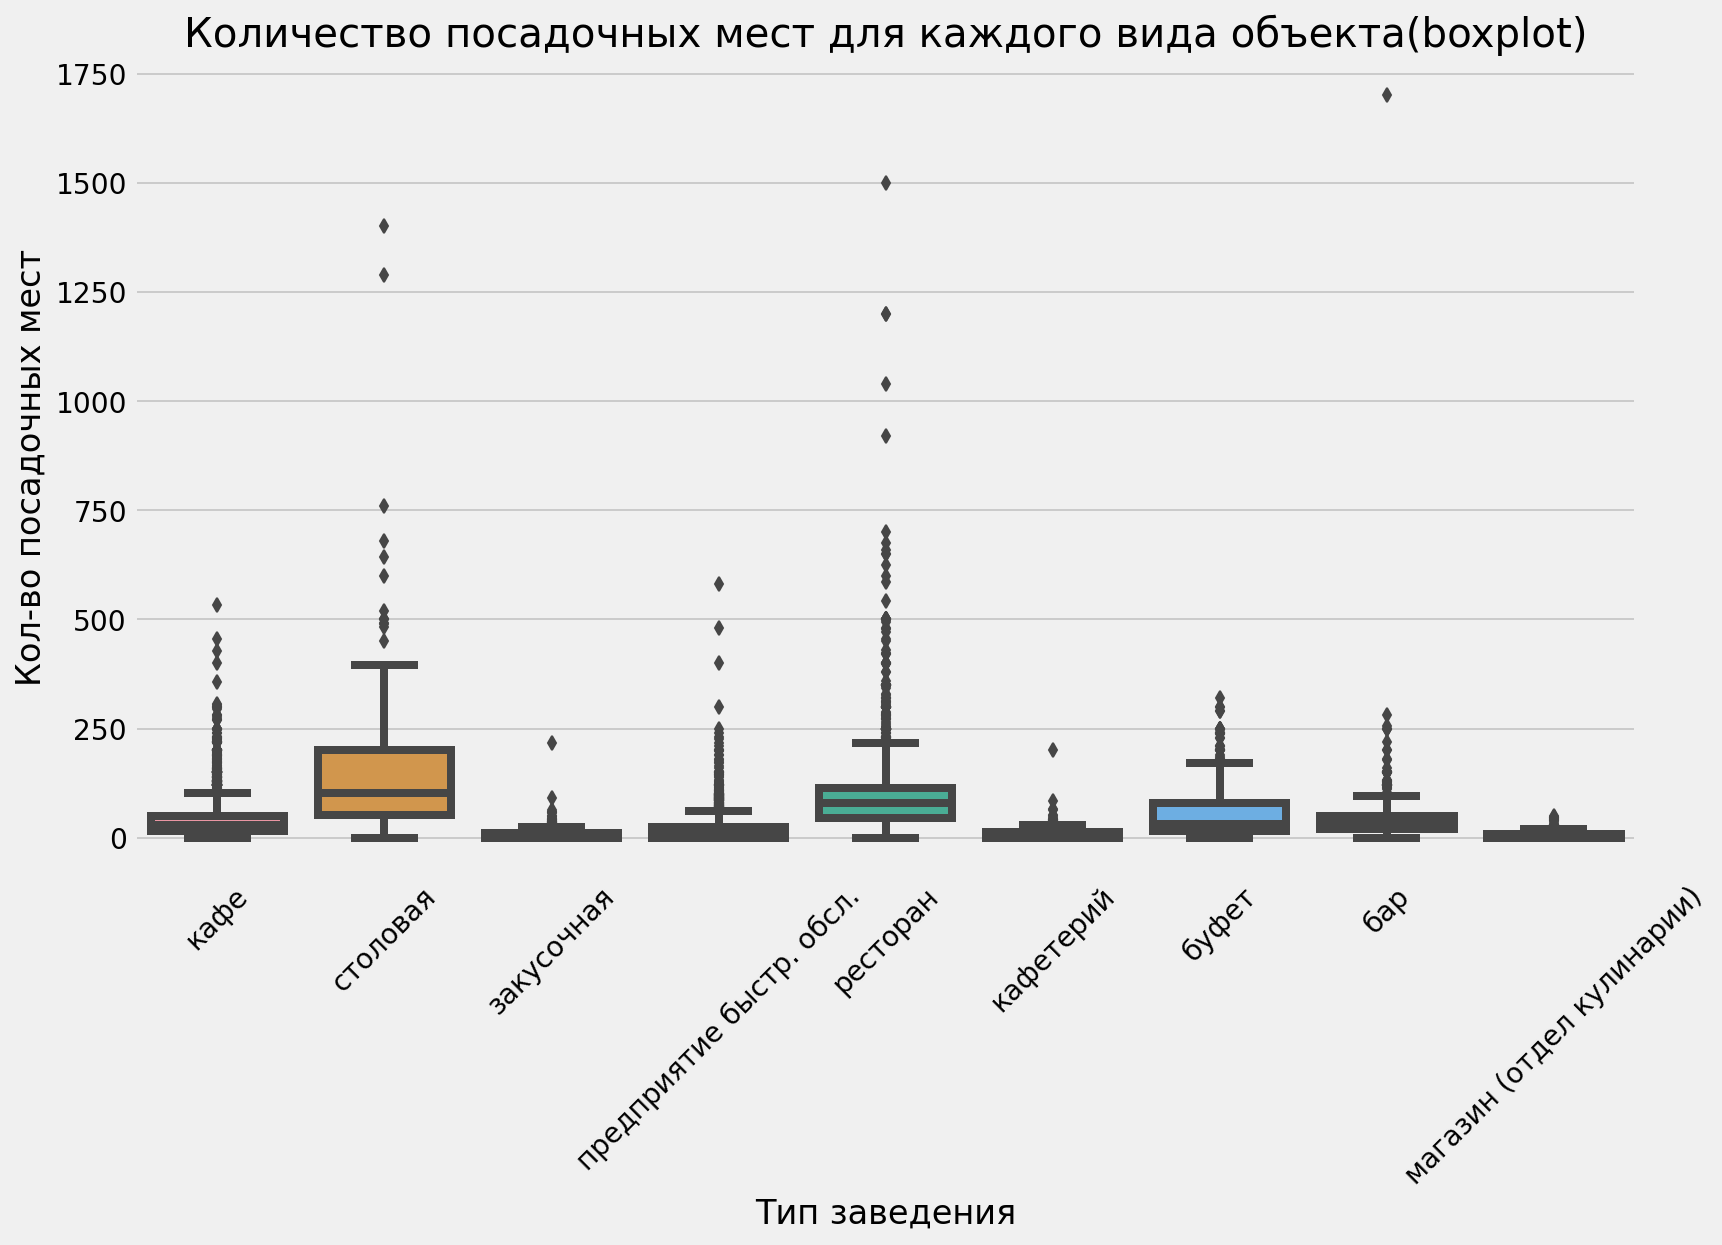

In [29]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(data=rest_data, x='object_type', y='number')
ax.set_title('Количество посадочных мест для каждого вида объекта(boxplot)')
ax.set_xlabel('Тип заведения')
ax.set_ylabel('Кол-во посадочных мест')
plt.xticks(rotation=45)

_По графику видно большое кол-во выбросов, поэтому считать среднее не очень целесообразно. Правильнее взять медиану. Но для наглядности построим график по средней и по медиане._

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'кафе'),
  Text(1, 0, 'столовая'),
  Text(2, 0, 'закусочная'),
  Text(3, 0, 'предприятие быстр. обсл.'),
  Text(4, 0, 'ресторан'),
  Text(5, 0, 'кафетерий'),
  Text(6, 0, 'буфет'),
  Text(7, 0, 'бар'),
  Text(8, 0, 'магазин (отдел кулинарии)')])

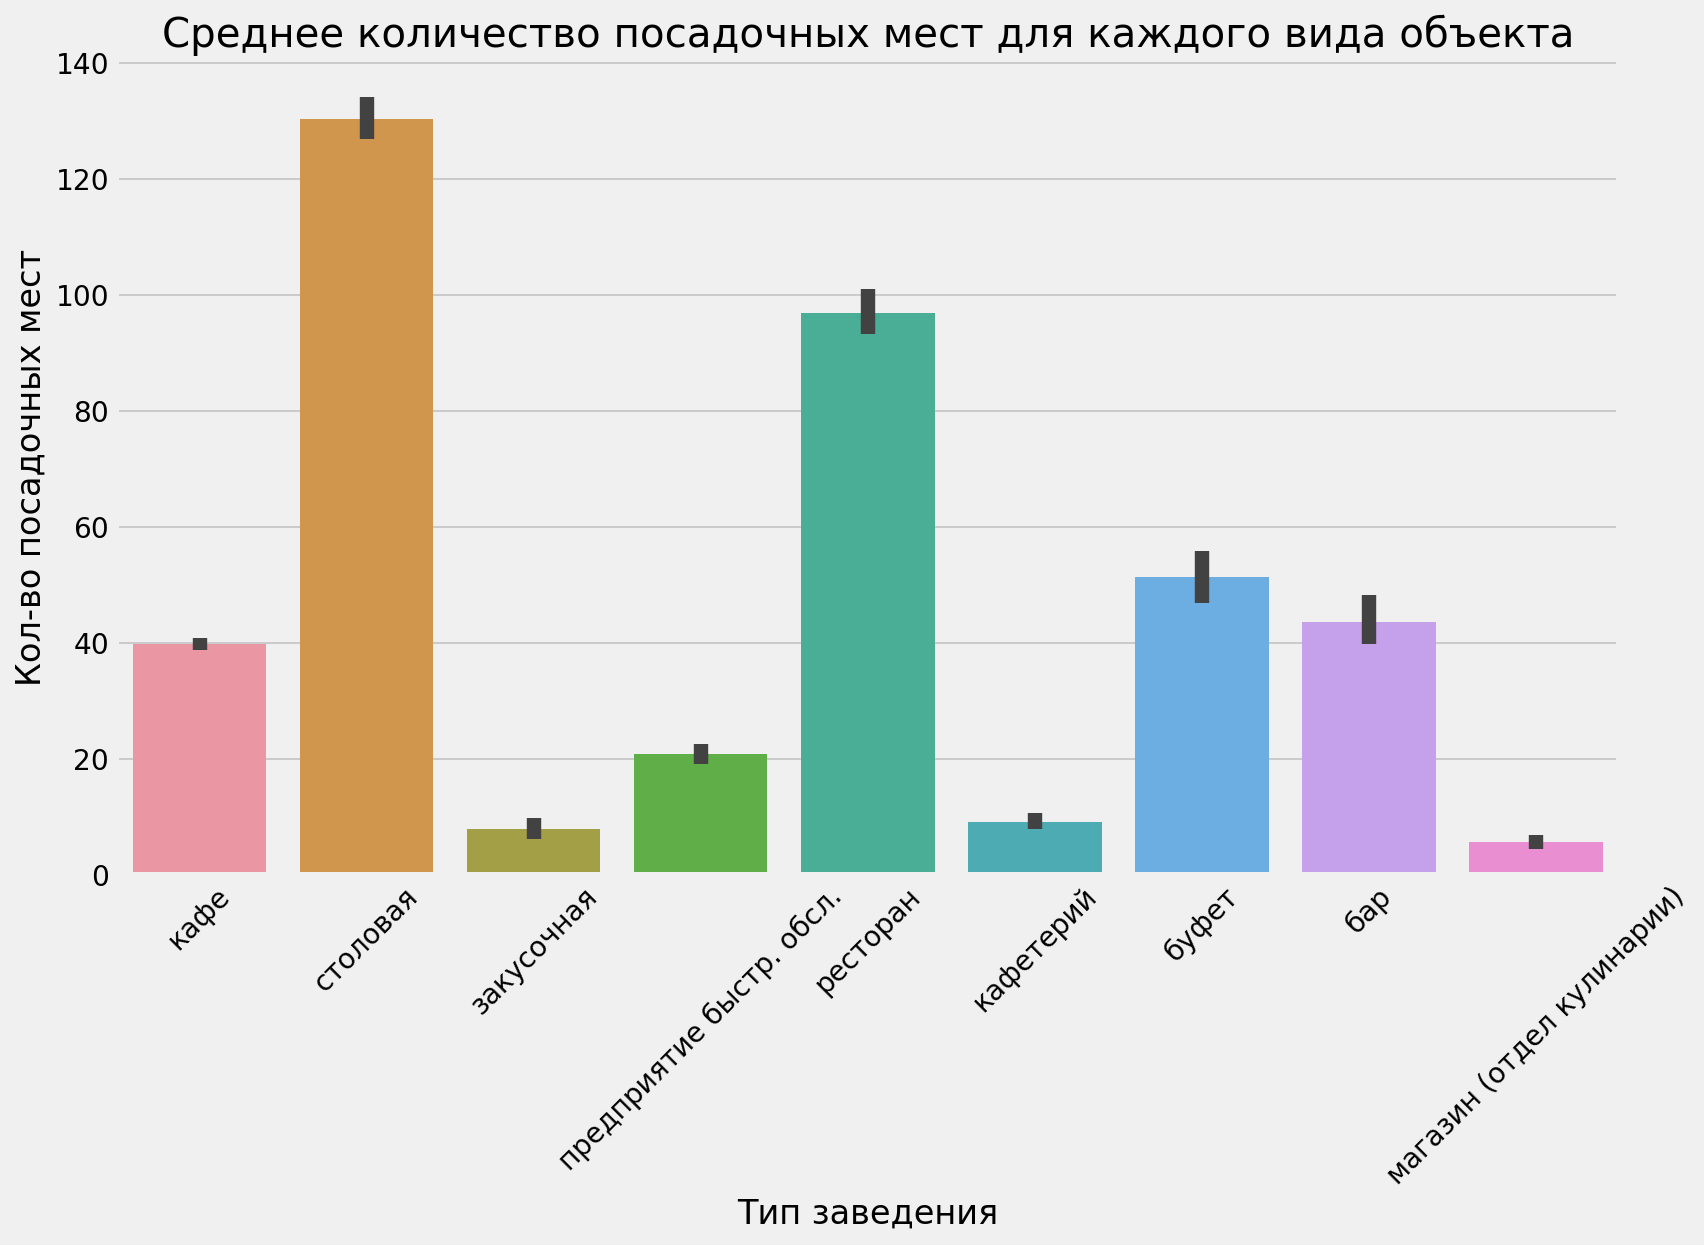

In [30]:
plt.figure(figsize=(12,7))
ax = sns.barplot(data=rest_data, x='object_type', y='number')
ax.set_title('Среднее количество посадочных мест для каждого вида объекта')
ax.set_xlabel('Тип заведения')
ax.set_ylabel('Кол-во посадочных мест')
plt.xticks(rotation=45)

__В графике по средней видно, что столовая лидирует примерно в 130 мест. Примерно 100 мест имеют рестораны, а кафе только после буфета и бара(что достаточно странно, особенно буфет) и имеют только 40 посадочных мест. Согласно СНиП Ресторан 50-200 чел, Столовая 50-200 чел, Кафе (общего типа) 50-200, Пивной бар 25-150, Буфет 8-50. Основная странность заключается в буфете, тк он обгоняет бары и кафе. Возможно через медиану увидим другую картину.__

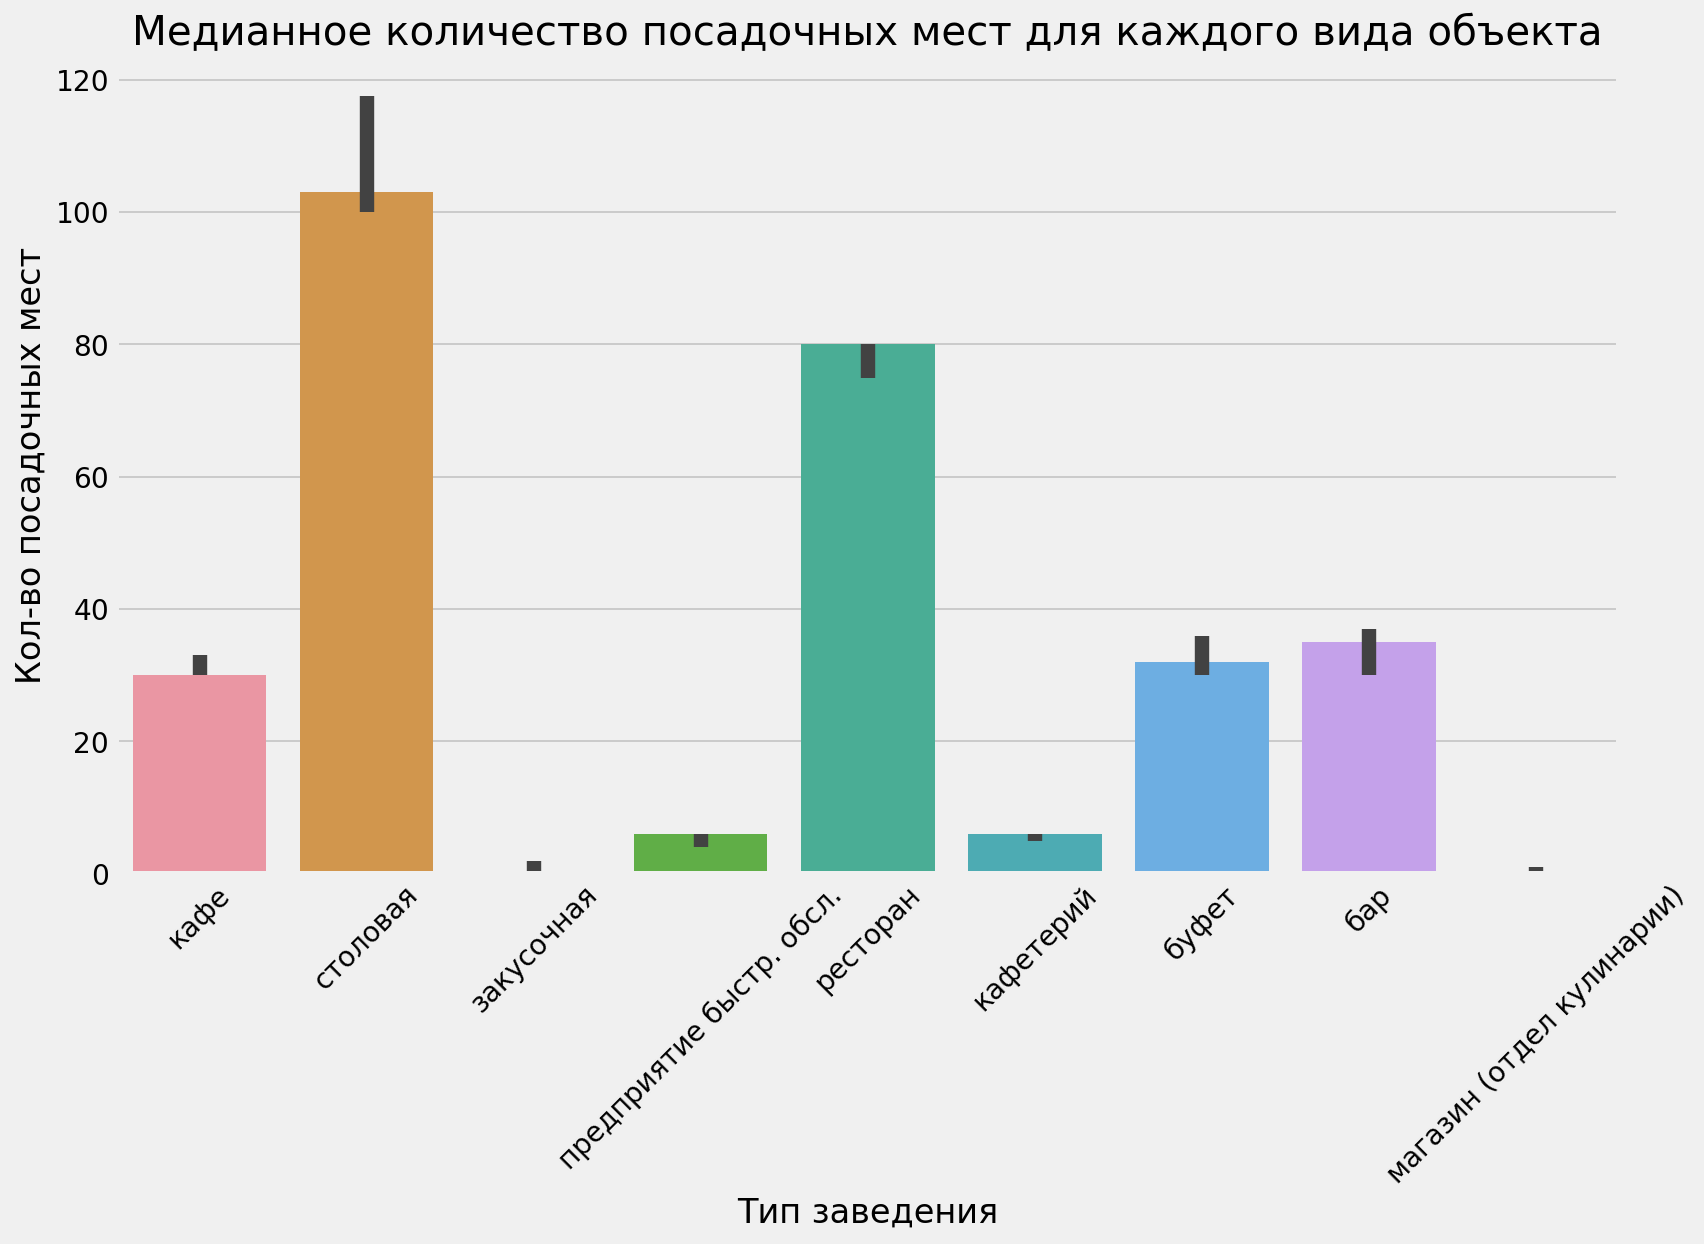

In [31]:
plt.figure(figsize=(12,7))
ax = sns.barplot(data=rest_data, x='object_type', y='number', estimator=median)
ax.set_title('Медианное количество посадочных мест для каждого вида объекта')
ax.set_xlabel('Тип заведения')
ax.set_ylabel('Кол-во посадочных мест')
plt.xticks(rotation=45)
plt.show()

__Лидерство осталось у столовых и ресторанов, а вот буфет уже уступает барам и находится примерно на одном уровне с кафе. График по медиане больше схож с рекомендациями СНиПа. И если в графике по средней закусочные имели показатели около 8-10 человек, то уже по медиане около 2-3 человек, так же и с магазинами кулинарии.__

---
#### 6. Извлечение в отдельный столбец информацию об улице из столбца address.

In [32]:
#разделение адреса по запятой с пробелом
rest_data['split_adress'] = rest_data['address'].str.split(', ')

In [33]:
#функция получения улицы из адреса
def street(row):
    name=row['split_adress'][1]
    return name        

In [34]:
#применение функции street
rest_data['name_street'] = rest_data.apply(street, axis=1)

In [35]:
#функция проверки - является значения индекса 1 улицей
def check(row):
    house=re.search('дом$|^дом', row['name_street'])
    city=re.search('город$|^город', row['name_street'])
    village=re.search('поселение$|^поселение', row['name_street'])
    if house == None:
        if city == None:
            if village == None:
                return 'OK'
            else:
                return 'Поселение'
        else:
            return 'Город'
    else:
        return 'Дом'

In [36]:
rest_data['check'] = rest_data.apply(check, axis=1)

In [37]:
#функция замены, если не является
def correct_street(row):
    if row['check'] == 'Город':
        x=row['split_adress'][2]
        return x
    if row['check'] == 'Поселение':
        y=row['split_adress'][2]
        return y
    if row['check'] == 'Дом':
        z=row['split_adress'][0]
        return z
    else:
        return row['name_street']

In [38]:
rest_data['correct_street'] = rest_data.apply(correct_street, axis=1)

In [39]:
#датасет с поселениями, городами спутниками и тд
other_location = rest_data[(rest_data['check'] != 'OK') & (rest_data['check'] != 'Дом')]

In [40]:
rest_data = rest_data[(rest_data['check'] == 'OK') | (rest_data['check'] == 'Дом')]

In [41]:
print('Доля исключаемых данных:', round(other_location.shape[0] / rest_data.shape[0], 3))

Доля исключаемых данных: 0.056


In [42]:
#удаление вспомогательных столбцов
rest_data=rest_data.drop(['check', 'name_street', 'split_adress'], axis=1)

---
#### 7. График топ-10 улиц по количеству объектов общественного питания.

In [43]:
#группировка по названию улицы с подсчетом заведений на ней
top_street = rest_data.groupby('correct_street').agg({'id':'nunique'}).reset_index()\
.sort_values('id', ascending=False).rename(columns={'id':'counts'})
top_street['correct_street'] = top_street['correct_street'].str.lower()

In [44]:
#первые топ 10 улиц
top10_street=top_street.head(10)

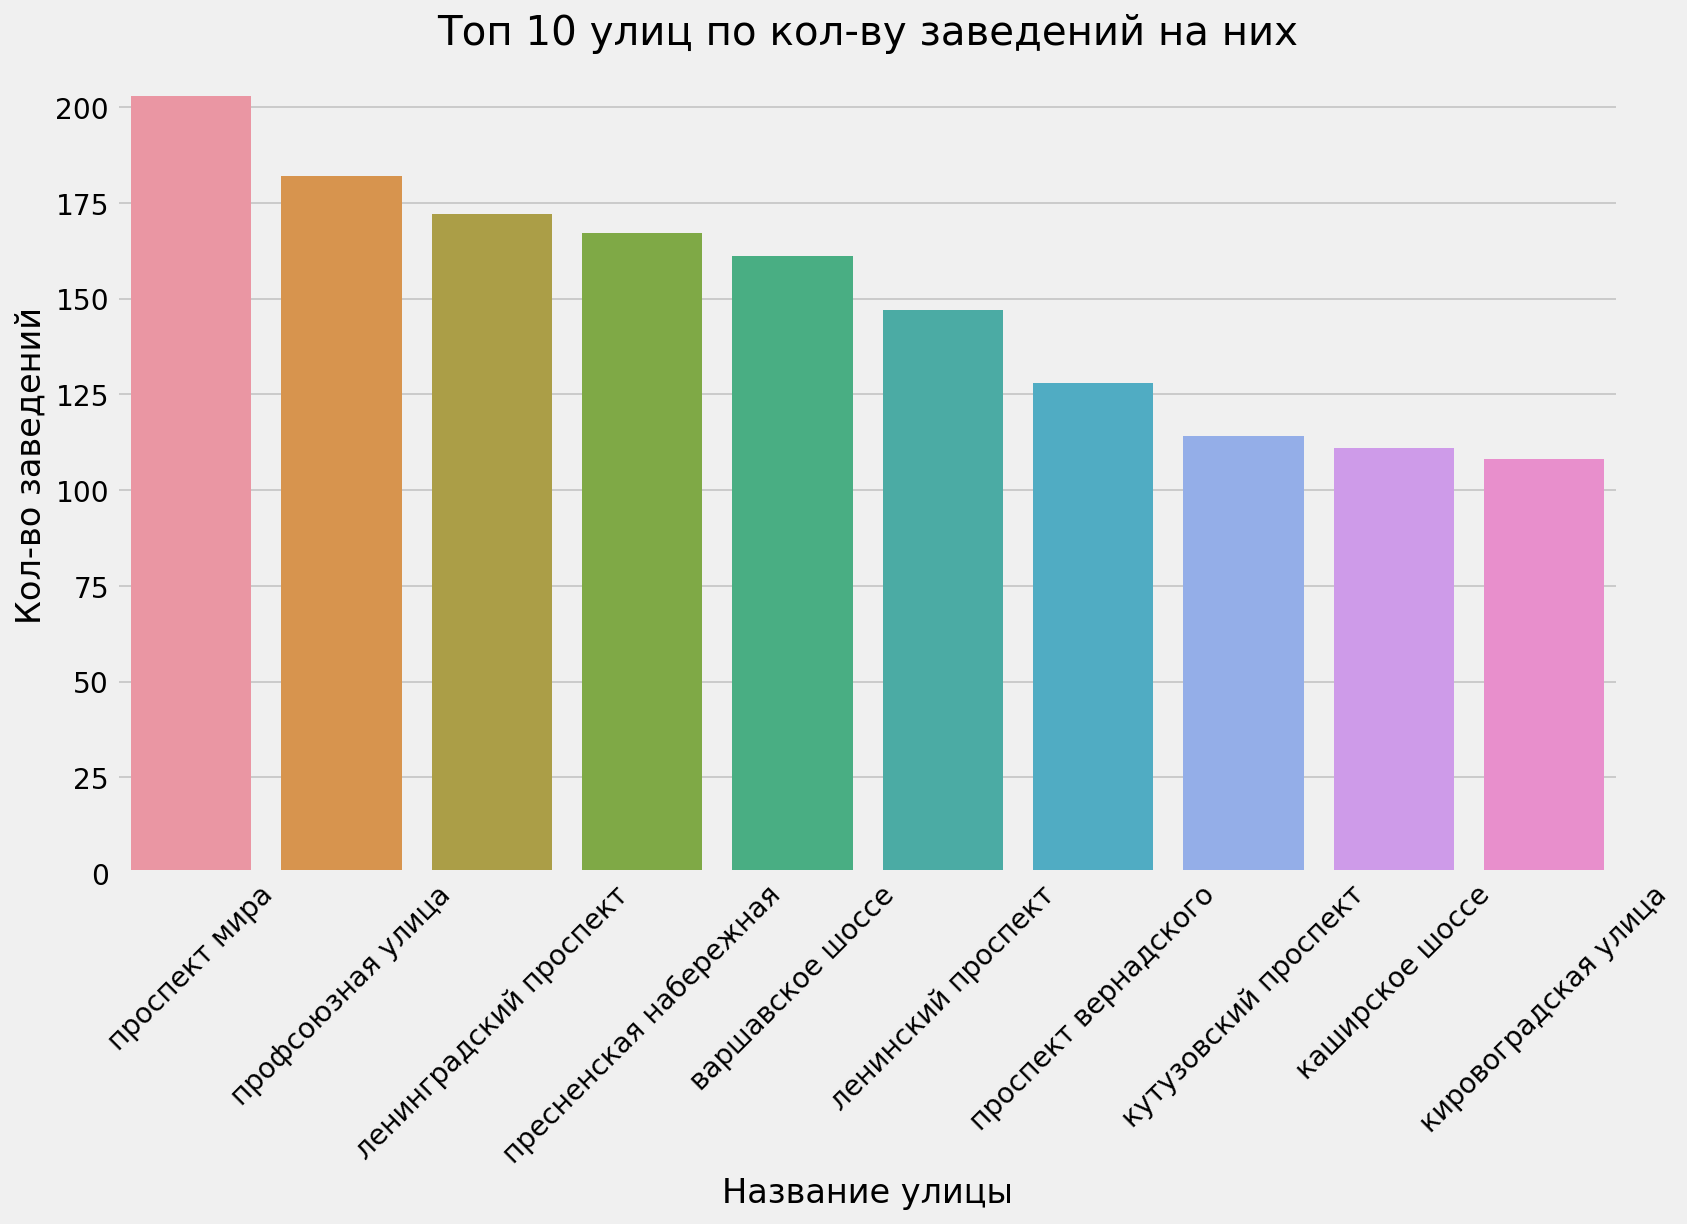

In [45]:
plt.figure(figsize=(12,7))
ax = sns.barplot(data=top10_street, x='correct_street', y='counts')
ax.set_title('Топ 10 улиц по кол-ву заведений на них')
ax.set_xlabel('Название улицы')
ax.set_ylabel('Кол-во заведений')
plt.xticks(rotation=45)
plt.show()

___Данные улицы наиболее популярны для открытия заведений общественного питания на них.Наибольшее кол-во заведений на проспекте Мира, наименьшее - Кировоградская улица.___

In [46]:
#датасет с округами, районами и улицами
districts = pd.read_csv(r'C:\Users\dshf\Desktop\portfolio\Рынок заведений общественного питания Москвы\data\mosgaz-streets (2).csv')
districts['streetname'] = districts['streetname'].str.lower()
districts.sample(10)

streetname  areaid okrug                       area
4001                      улица грина     130  ЮЗАО      Район Северное Бутово
2648  1-й сельскохозяйственный проезд      81  СВАО            Район Ростокино
2084                валдайский проезд      64   САО       Молжаниновский район
863            3-я владимирская улица      32   ВАО               Район Перово
4356                  самарская улица      16   ЦАО            Мещанский район
3459              мкад, 15-й километр     112  ЮВАО              Район Капотня
71       малый предтеченский переулок      17   ЦАО          Пресненский район
497                 зацепская площадь      14   ЦАО        Район Замоскворечье
1466            улица наташи ковшовой      50   ЗАО  Район Очаково-Матвеевское
533              озерковский переулок      14   ЦАО        Район Замоскворечье

In [47]:
#объединение датасетов по названию улицы
merged_top10_area = top10_street.merge(districts[['streetname', 'area', 'okrug']],\
                                  left_on='correct_street', right_on='streetname', how='inner')
merged_top10_area.head(5)

correct_street  counts     streetname                area okrug
0  проспект мира     203  проспект мира  Алексеевский район  СВАО
1  проспект мира     203  проспект мира   Ярославский Район  СВАО
2  проспект мира     203  проспект мира  Район Марьина роща  СВАО
3  проспект мира     203  проспект мира  Останкинский район  СВАО
4  проспект мира     203  проспект мира     Район Ростокино  СВАО

_Некоторые улицы находятся в нескольких районах, поэтому имеется много дублей. Больший смысл имеет извлекать Административный округ._

In [48]:
#группировка по улице и кол-ву заведение с выведением самого популярного округа у улицы
top_disrticts = merged_top10_area.groupby(['correct_street', 'counts'])['okrug']\
.agg(lambda x: pd.Series.mode(x)[0]).reset_index().sort_values('counts', ascending=False)
top_disrticts

correct_street  counts okrug
8           проспект мира     203  СВАО
9       профсоюзная улица     182  ЮЗАО
4  ленинградский проспект     172   САО
6  пресненская набережная     167   ЦАО
0        варшавское шоссе     161   ЮАО
5      ленинский проспект     147  ЮЗАО
7    проспект вернадского     128   ЗАО
3    кутузовский проспект     114   ЗАО
1         каширское шоссе     111   ЮАО
2    кировоградская улица     108   ЮАО

In [49]:
fig = go.Figure(data=[go.Pie(labels=top_disrticts['okrug'], values=top_disrticts['counts'])])
fig.update_layout(title_text='Кол-во заведений в округах из топ 10 улиц')
fig.show()

fig = px.histogram(top_disrticts, x='okrug', title='Кол-во улиц в округах из топ 10 улиц')
fig.update_xaxes(title_text='Название округа')
fig.update_yaxes(title_text='Кол-во улиц')
fig.show()

**Круговая диграмма показывает двух явных лидеров по кол-ву заведений, а вот столбчатый график говорит, о том, что ЮАО имеет 3 улицы из топ 10, а ЮЗАО только 2 улицы. То есть имеем 2 округа(ЮАО,ЮЗАО), которые взяли на себя 5 улиц с наибольшим кол-вом заведений из возможных 10ти и я бы считал эти два округа наиболее удачными для открытия заведения.**

---
#### 8. Расчет числа улиц с одним объектом общественного питания.

In [50]:
print('Кол-во улиц с одним заведением:', top_street[top_street['counts'] == 1].shape[0])

Кол-во улиц с одним заведением: 549


In [51]:
#датасет с одним заведением на улице
only_1_building = top_street[top_street['counts'] == 1]

In [52]:
#объединение датафреймов с округами и улиц
only_1_building_mrg_1 = only_1_building.merge(districts[['streetname', 'area', 'okrug']]\
                                            , left_on='correct_street', right_on='streetname', how='inner')
only_1_building_mrg_1.head()

correct_street  counts               streetname  \
0  3-й проезд подбельского       1  3-й проезд подбельского   
1    3-й стрелецкий проезд       1    3-й стрелецкий проезд   
2    1-й сетуньский проезд       1    1-й сетуньский проезд   
3     1-й рижский переулок       1     1-й рижский переулок   
4    1-й силикатный проезд       1    1-й силикатный проезд   

                      area okrug  
0        Район Богородское   ВАО  
1       Район Марьина роща  СВАО  
2            Район Раменки   ЗАО  
3       Алексеевский район  СВАО  
4  Район Хорошево-Мневники  СЗАО

In [53]:
#извелечение моды районов
only_1_building_mrg = only_1_building_mrg_1.groupby(['correct_street'])['okrug', 'area']\
.agg(lambda x: pd.Series.mode(x)[0]).reset_index()
only_1_building_mrg.head()

<ipython-input-53-1e33fbbdeafe>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



correct_street okrug             area
0    1-й балтийский переулок   САО   Район Аэропорт
1     1-й басманный переулок   ЦАО  Басманный район
2    1-й ботанический проезд  СВАО   Район Свиблово
3    1-й вешняковский проезд  ЮВАО  Рязанский район
4  1-й голутвинский переулок   ЦАО   Район Якиманка

In [54]:
#районы, с наибольшем кол-вом улиц с одним заведением.
top10_disrt_bad = only_1_building_mrg.groupby('area')['correct_street']\
.count().reset_index().sort_values('correct_street', ascending=False).head(10)

<Figure size 432x288 with 0 Axes>

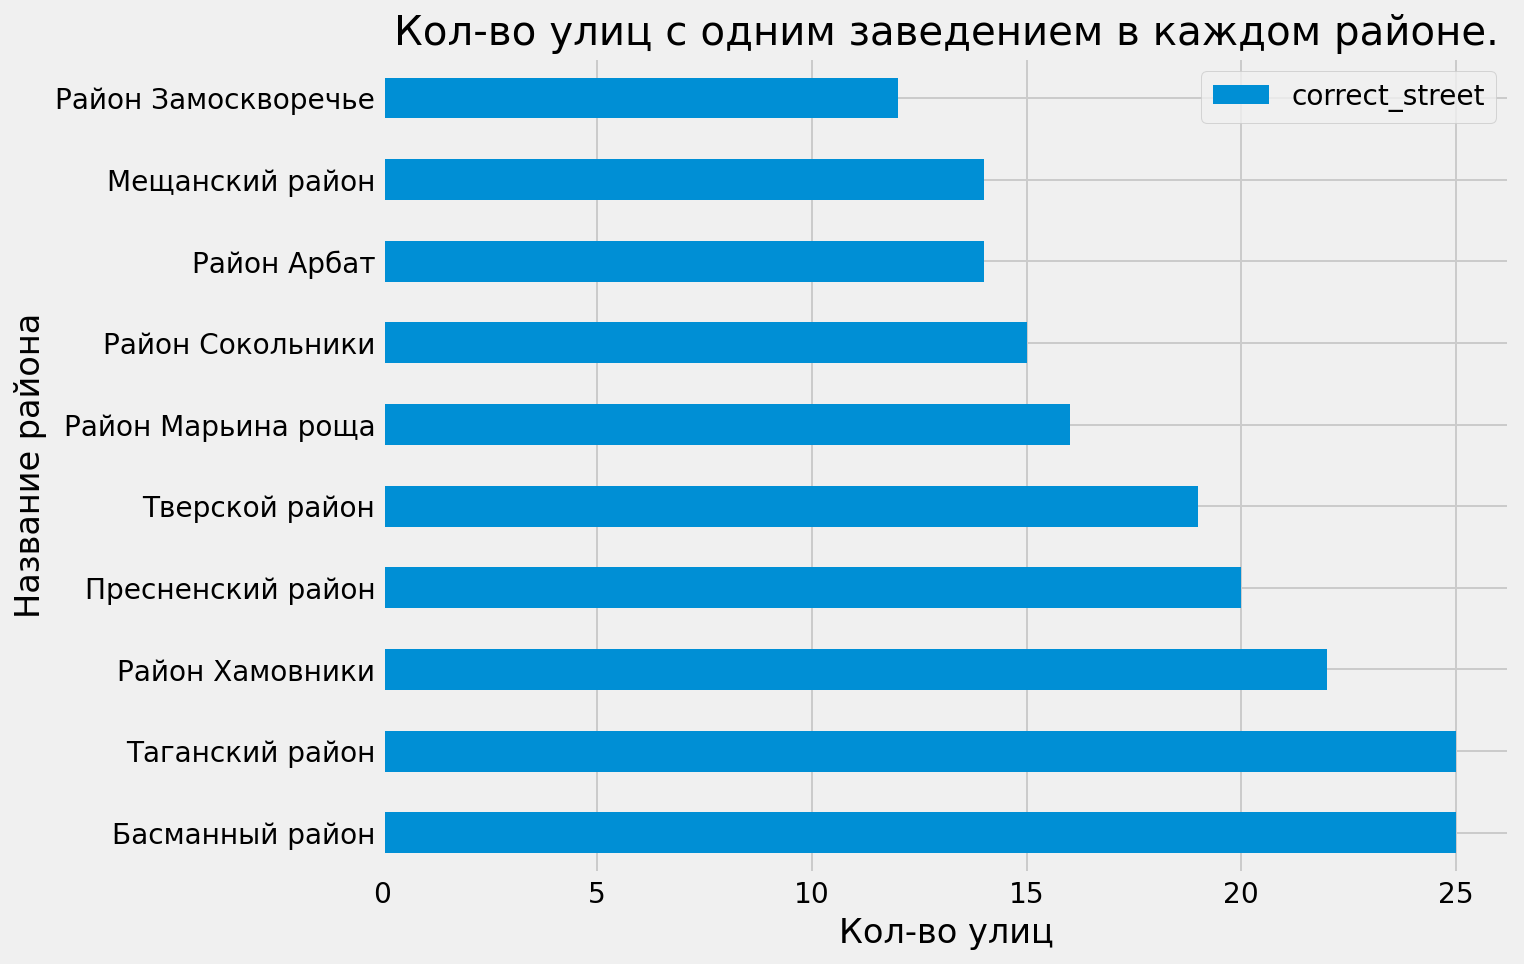

In [55]:
plt.figure()
top10_disrt_bad.plot.barh(x='area', y='correct_street', figsize=(9,7))
plt.xlabel('Кол-во улиц')
plt.ylabel('Название района')
plt.title('Кол-во улиц с одним заведением в каждом районе.')
plt.show()

***В целом можно сказать, что данные районы не очень популярны среди заведений, тк там достаточно много улиц с 1 заведением. И можно посмотреть в каких округах они находятся, может получится так, что мы получим округа из предидущего расчета, в котором мы выявили наиболее удачные округа для открытия заведения.***

In [56]:
#создание списка топ10 непопулярных райнов
top10_disrt_bad_lst = top10_disrt_bad['area'].tolist()
top10_disrt_bad_lst

['Басманный район',
 'Таганский район',
 'Район Хамовники',
 'Пресненский район',
 'Тверской район',
 'Район Марьина роща',
 'Район Сокольники',
 'Район Арбат',
 'Мещанский район',
 'Район Замоскворечье']

In [57]:
#нахождения округов этих райнов
bad_okrug = districts[districts['area'].isin(top10_disrt_bad_lst)][['okrug', 'area']].drop_duplicates()

In [58]:
fig = px.histogram(bad_okrug, x='okrug', title='Кол-во районов из топ10 непопулярных райнов по округам')
fig.update_xaxes(title_text='Название округа')
fig.update_yaxes(title_text='Кол-во районов')
fig.show()

**По топ10 можно сделать вывод, что абсолютно доминирует ЦАО, он имеет 8 районов из 10, где наибольшее кол-во улиц с одним заведением. И так же засветились ВАО и СВАО. Результаты абсолютно устраивают, тк лучшими округами для открытия заведения были ЮАО, ЮЗАО, что не противоречит текущим выводам.**

---
#### 9. Выявление закономерностей в распределении количества посадочных мест для улиц с большим количеством объектов общественного питания.

In [59]:
#список из топ10 улиц с наибольшим кол-вом заведений
top10_street_lst = top10_street['correct_street'].tolist()
top10_street_lst

['проспект мира',
 'профсоюзная улица',
 'ленинградский проспект',
 'пресненская набережная',
 'варшавское шоссе',
 'ленинский проспект',
 'проспект вернадского',
 'кутузовский проспект',
 'каширское шоссе',
 'кировоградская улица']

In [60]:
#приведение к нижнему регистру улиц из осн датасета
rest_data['correct_street'] = rest_data['correct_street'].str.lower()
data_top10 = rest_data[rest_data['correct_street'].isin(top10_street_lst)]
data_top10.head()

id      object_name  chain               object_type  \
151  155973  Кафе «Андерсон»   True                      кафе   
152   23618    Кафе «Subway»   True                      кафе   
153  155852   Кафе «Ламаджо»  False                      кафе   
154  152556    Шаурма в пите  False  предприятие быстр. обсл.   
155  120658          Выпечка  False                 кафетерий   

                                              address  number object_name_new  \
151             город Москва, Варшавское шоссе, дом 2     150        anderson   
152   город Москва, Варшавское шоссе, дом 7, корпус 1      36          subway   
153            город Москва, Варшавское шоссе, дом 29      30        lamadzho   
154  город Москва, Варшавское шоссе, дом 72, корпус 2       0  shaurma v pite   
155           город Москва, Варшавское шоссе, дом 100       2        vypechka   

       correct_street  
151  варшавское шоссе  
152  варшавское шоссе  
153  варшавское шоссе  
154  варшавское шоссе  
155  варшавское шоссе

In [61]:
fig = px.box(data_top10, x='correct_street', y='number', range_y=(-100, 600)\
             , title='Распределении количества посадочных мест для улиц с большим количеством объектов')
fig.update_xaxes(title_text='Название улицы')
fig.update_yaxes(title_text='Кол-во посадочных мест')
fig.show()

**Ранее были выявлены наиболее удачные округа и наиболее неудачные районы Москвы для открытия заведения. Если же говорить про самые удачные улицы для открытия бизнеса, то на графике можно увидеть разницу в медианных значениях кол-ва посадочных мест для каждой улицы. Тем самым, ориентируясь на размер нашего кафе, можем выделить наиболее удачные улицы для наиболее маленьких заведений и наиболее больших заведений. Например, на улице Профсоюзная, даже выбросы имеют плотную структуру и медианное значение 24.5. Так же в эту группу можно взять Пресненскую набережную(много выбросов, но короткий ус и самое маленькое тело), Кировоградскую улицу, Варшавское шоссе.**

### Вывод и рекомендации: <a class="anchor" id="second_1_prestep"></a>

В ходе работы был исследован рынок заведений общественного питания Москвы. В сырых данных имелись неверные типы данных, названия с разными регистрами и латиницей и кириллицей. В результате предобработки было выявлено и удалено 85 дубликатов. Также данные были проверены на предмет разных заглушек. Далее по обработанных данным был проведен анализ, в ходе которого выяснилось, что **самыми популярными заведениями общ. питания являются - кафе(39.7%), столовая(16.9%), ресторан(14.9%)**. Также **сетевыми заведениями являются около 20% всех заведений**. Среди них самыми популярными являются предприятие быстрого обслуживания. На втором месте - магазин(отдел кулинарии), третье - кафе. **Самые несетевые типы - столовые, буфеты, бары. Для сетевых заведений характерно большое кол-во заведений со средним количеством мест до 70-80.** Узнав медианное кол-во мест для каждого типа объекта, видно, что столовая имеет самое большое значение, затем ресторан и примерно на одном уровне кафе, буфет и бар. Далее получили топ10 улиц по количество заведений на них и можно так же выделить **наиболее удачные округа для открытия бизнеса по этим улицам(ЮАО,ЮЗАО)**. Так же были найдены **улицы с одним заведением и найдены их районы и округа(ЦАО, ВАО, СВАО). Их можно называть, как сложными для открытия бизнеса**, тк заведения общественного питания там пользуются небольшим спросом. Хотя если говорить про ЦАО, то я думаю, тк это центр, то порог вхождения туда достаточно высокий и в центре скорее всего больше небольших улиц, чем за садовым кольцом. Если же все таки говорить про конкретные улицы из топ10 по кол-ву заведений, то тут тоже можно разделить, как улицы с наибольшим кол-во посетитлей и меньшим. Например, на улице Профсоюзная, даже выбросы имеют плотную структуру и медианое значение 24.5. Так же в эту группу можно взять Пресненскую набережную(много выбросов, но короткий ус и самое маленькое тело), Кировоградскую улицу, Варшавское шоссе. 


***В данном выводе можно найти ответы на вопросы:***

___Что чаще всего открывают сетевые компании? - Предприятие быстрого обслуживания___

___Какой тип заведения чаще всего открывают в Москве? - Кафе___

___Популярные улицы Москвы для открытия заведения? - 'проспект мира', 'профсоюзная улица', 'ленинградский проспект', 'пресненская набережная', 'варшавское шоссе', 'ленинский проспект', 'проспект вернадского', 'кутузовский проспект', 'каширское шоссе', 'кировоградская улица'___

___Наиболее популярные округа Москвы для открытия заведения? - ЮАО, ЮЗАО___

___Непопулярные районы, округа Москвы для открытия заведения? - ЦАО, ВАО, СВАО___


### Шаг №3. Презентация: <a class="anchor" id="third_step"></a>

https://disk.yandex.ru/i/dWJL_kGkj6vLWg